## Section 5: Machine Learning
Using the dataset from https://archive.ics.uci.edu/ml/datasets/Car+Evaluation, create a machine learning model to predict the buying price given the following parameters:

Maintenance = High
Number of doors = 4
Lug Boot Size = Big
Safety = High
Class Value = Good


In [14]:
## Data Exploration

import pandas as pd

mydf = pd.read_csv('cardata.csv')

print(mydf.head(5))

   Price  Maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc


Data is completely categorical.

Use onehotencoding to perform simple logistic regression and see.

In [15]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
target = mydf['class']
X = mydf.loc[:, ~mydf.columns.isin(['class','Price'])]

enc.fit(X)

enc.categories_
independ_variables_OHE = enc.transform(X).toarray()
# enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])
# enc.get_feature_names_out(['gender', 'group'])

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    independ_variables_OHE, 
    target, 
    test_size=0.33, 
    random_state=42)

In [17]:
from sklearn.linear_model import LogisticRegression

# Create an instance of Logistic Regression Classifier and fit the data.
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

print(logreg.score(X_test, y_test))

0.8266199649737302


### Observations from first round of data.

Very poor accuracy from simple logistic regression. Some exploration of cooccurrence has to be done., and feature extraction can be done. Try Decision trees?

In [18]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

clf = clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

0.7618213660245184


Worse. Do some data exploration.

In [19]:
for col in mydf.columns:
    print(mydf[col].value_counts())   

vhigh    432
high     432
med      432
low      432
Name: Price, dtype: int64
vhigh    432
high     432
med      432
low      432
Name: Maint, dtype: int64
2        432
3        432
4        432
5more    432
Name: doors, dtype: int64
2       576
4       576
more    576
Name: persons, dtype: int64
small    576
med      576
big      576
Name: lug_boot, dtype: int64
low     576
med     576
high    576
Name: safety, dtype: int64
unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64


Each row is unique set of data. Dataset is not suitable for predicting Price using the other independent variables. Try to run regression purely on the supposed dependent variable.
Dataset seems to be manufactured for predicting Class, with Class being the only reasonable predictor to use.

Try all other combinations of regression variables since computation is not limiting.

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

def get_score(predictor_variables):

    enc = OneHotEncoder(handle_unknown='ignore')
    target = mydf['Price']
    X = mydf.loc[:, list(predictor_variables)]

    enc.fit(X)
    independ_variables_OHE = enc.transform(X).toarray()
    # enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])
    # enc.get_feature_names_out(['gender', 'group'])

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(
        independ_variables_OHE, 
        target, 
        test_size=0.33, 
        random_state=42)

    from sklearn.linear_model import LogisticRegression

    # Create an instance of Logistic Regression Classifier and fit the data.
    logreg = LogisticRegression(C=1e5)
    logreg.fit(X_train, y_train)

    return logreg.score(X_test, y_test)

import itertools

predictor_columns = [i for i in mydf.columns if i not in ['Price','class']]

my_records = []
for i in range(len(predictor_columns)):
    for j in itertools.combinations(predictor_columns,i+1):
        j = list(j) + ['class']
        score = get_score(j)

        
        my_records.append({
            'Predictors': ','.join(j),
            'Score': score
        })

myscore_df = pd.DataFrame.from_records(my_records)
myscore_df.sort_values('Score', ascending=False)

,Predictors,Score
0,"Maint,class",0.323993
28,"Maint,persons,lug_boot,safety,class",0.322242
20,"Maint,lug_boot,safety,class",0.318739
1,"doors,class",0.318739
18,"Maint,persons,lug_boot,class",0.313485
14,"lug_boot,safety,class",0.311734
5,"Maint,doors,class",0.311734
30,"Maint,doors,persons,lug_boot,safety,class",0.309982
8,"Maint,safety,class",0.308231
10,"doors,lug_boot,class",0.306480


## Use best performing model for predicting price?

Best performing model uses, *Maint*, and *class*.

In [21]:
from sklearn.preprocessing import OneHotEncoder

def get_score(predictor_variables):

    enc = OneHotEncoder(handle_unknown='ignore')
    target = mydf['Price']
    X = mydf.loc[:, list(predictor_variables)]

    enc.fit(X)
    independ_variables_OHE = enc.transform(X).toarray()
    # enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])
    # enc.get_feature_names_out(['gender', 'group'])

    from sklearn.model_selection import train_test_split

    split_df = train_test_split(
        independ_variables_OHE, 
        target, 
        test_size=0.33, 
        random_state=42)

    from sklearn.linear_model import LogisticRegression

    X_train, X_test, y_train, y_test = split_df
    # Create an instance of Logistic Regression Classifier and fit the data.
    logreg = LogisticRegression(C=1e5)
    logreg.fit(X_train, y_train)
    
    return logreg, enc, split_df

predictor_columns = ['class','Maint']

# Maintenance = High
# Number of doors = 4
# Lug Boot Size = Big
# Safety = High
# Class Value = Good
my_logreg_model, logreg_enc, split_df = get_score(predictor_columns)
X_train, X_test, y_train, y_test = split_df

              precision    recall  f1-score   support

        high       0.26      0.30      0.28       141
         low       0.64      0.20      0.30       146
         med       0.37      0.17      0.24       139
       vhigh       0.30      0.62      0.40       145

    accuracy                           0.32       571
   macro avg       0.39      0.32      0.31       571
weighted avg       0.40      0.32      0.31       571



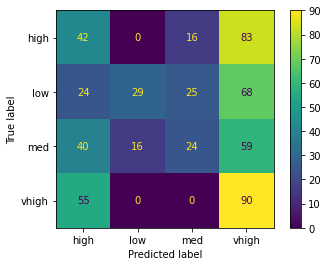

In [22]:
## Evaluation of logreg model
y_predictions = my_logreg_model.predict(X_test)
fpr = metrics.classification_report(y_test, y_predictions)
print(fpr)

my_cm = metrics.confusion_matrix(y_test, y_predictions, labels=my_logreg_model.classes_)
displ = metrics.ConfusionMatrixDisplay(my_cm, display_labels=my_logreg_model.classes_)

displ.plot()

Based on the above evaluation and the cleanness of data received, we can see that the accuracy has an uplift from random at 0.25 to 0.32. There is however, a high tendency for the model to predict a vhigh price.

We can try switching this into a binary model for prediction.

c:\Users\Nelson\Desktop\Nelson\Programming\govtech_de_test\.venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nelson\Desktop\Nelson\Programming\govtech_de_test\.venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nelson\Desktop\Nelson\Programming\govtech_de_test\.venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

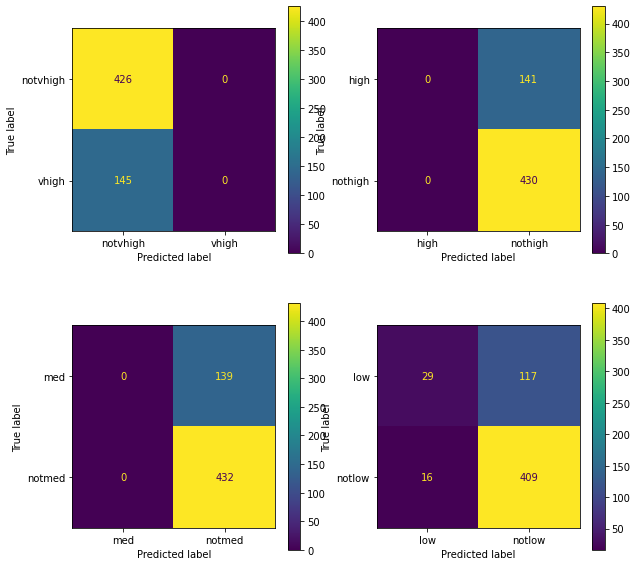

In [23]:
## Try switching to binary predictions?
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
predictor_columns = ['class','Maint']

def switch_to_binary_model():
    for prices in mydf['Price'].unique():

        my_binary_df = mydf.copy(deep=True)
        my_binary_df.loc[~(my_binary_df['Price']==prices),'Price'] = f'not{prices}'

        enc = OneHotEncoder(handle_unknown='ignore')
        target = my_binary_df['Price']
        X = my_binary_df.loc[:, predictor_columns]

        enc.fit(X)
        independ_variables_OHE = enc.transform(X).toarray()
        # enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])
        # enc.get_feature_names_out(['gender', 'group'])

        from sklearn.model_selection import train_test_split

        split_df = train_test_split(
            independ_variables_OHE, 
            target, 
            test_size=0.33, 
            random_state=42)

        from sklearn.linear_model import LogisticRegression

        X_train, X_test, y_train, y_test = split_df
        # Create an instance of Logistic Regression Classifier and fit the data.
        logreg = LogisticRegression(C=1e5)
        logreg.fit(X_train, y_train)
        
        yield logreg, enc, split_df

predictor_columns = ['class','Maint']

# Maintenance = High
# Number of doors = 4
# Lug Boot Size = Big
# Safety = High
# Class Value = Good

my_predictions = []

for my_binary_logreg_model, enc, split_df in switch_to_binary_model():
    X_train, X_test, y_train, y_test = split_df

    ## Evaluation of logreg model
    y_predictions = my_binary_logreg_model.predict(X_test)
    fpr = metrics.classification_report(y_test, y_predictions)
    my_predictions.append((y_test, y_predictions, my_binary_logreg_model.classes_))

import matplotlib.pyplot as plt 

fig,axes=plt.subplots(2,2, figsize=(10,10))
for my_predictions, ax in zip(my_predictions, axes.flatten()):
    test, pred, classes = my_predictions
    metrics.ConfusionMatrixDisplay.from_predictions(test, pred, labels=classes, ax=ax)

plt.show()

There is not enough meaningful information in the dependent variables to make a good prediction.

Use multivariate model to predict price.

In [24]:
print(
    my_logreg_model.predict(
        logreg_enc.transform(
            pd.DataFrame.from_records([{'Maint':'high','class':'good'}])
            ).toarray()
        )
    )

['low']


c:\Users\Nelson\Desktop\Nelson\Programming\govtech_de_test\.venv\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Price of car prediction: **Low**